# 1.1 From Time Series to Insights

# Imports

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from kats.consts import TimeSeriesData

# Load the dataset

In [2]:
# Stores
df_stores = pd.read_csv('../dataset/store_cities.csv', 
                        delimiter=',', 
                        dtype={'store_id':'category',
                               'storetype_id':'category',
                               'city_id':'category'})
# Product hierachy
df_product_hierachy = pd.read_csv('../dataset/product_hierarchy.csv', 
                                 delimiter= ',',
                                 dtype={'product_id':'category',
                                        'cluster_id':'category',
                                        'hierarchy1_id':'category',
                                        'hierarchy2_id':'category',
                                        'hierarchy3_id':'category',
                                        'hierarchy4_id':'category',
                                        'hierarchy5_id':'category'})
# Sales
df_sales = pd.read_csv('../dataset/sales.csv',
                       delimiter=',', 
                       dtype={"product_id":"category", 
                              "store_id":"category",
                              "promo_type_1":"category",
                              "promo_bin_1":"category",
                              "promo_type_2":"category",
                              "promo_bin_2":"category",
                              "promo_discount_2":"category",
                              "promo_discount_type_2":"category"},
                       parse_dates=["date"])

# Join hierachy and sales
df_sales = df_sales.join(df_product_hierachy.set_index('product_id'), on='product_id')
df_sales = df_sales.join(df_stores.set_index('store_id'), on='store_id')
df_sales.head()

,product_id,store_id,date,sales,revenue,stock,price,promo_type_1,promo_bin_1,promo_type_2,...,product_width,cluster_id,hierarchy1_id,hierarchy2_id,hierarchy3_id,hierarchy4_id,hierarchy5_id,storetype_id,store_size,city_id
0,P0001,S0002,2017-01-02,0.0,0.00,8.0,6.25,PR14,NaN,PR03,...,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,39,C007
1,P0001,S0012,2017-01-02,1.0,5.30,0.0,6.25,PR14,NaN,PR03,...,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,28,C005
2,P0001,S0013,2017-01-02,2.0,10.59,0.0,6.25,PR14,NaN,PR03,...,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,33,C026
3,P0001,S0023,2017-01-02,0.0,0.00,6.0,6.25,PR14,NaN,PR03,...,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,31,C008
4,P0001,S0025,2017-01-02,0.0,0.00,1.0,6.25,PR14,NaN,PR03,...,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,25,C024


# KATS
Kats (Kits to Analyze Time Series) is a light-weight, easy-to-use, extenable, and generalizable framework to perform time series analysis in Python. Time series analysis is an essential component of data science and engineering work. Kats aims to provide a one-stop shop for techniques for univariate and multivariate time series including:

1. Forecasting
2. Anomaly and Change Point Detection
3. Feature Extraction

Have a look at the example notebooks at [GitHub](https://github.com/facebookresearch/Kats/tree/main/tutorials)
We will look only at parts of the tutorials here:

## Kats Basics
`TimeSeriesData` is the basic data structure in Kats to represented univariate and multivariate time series.  There are two ways to initiate it, henceforth referred to as "Method 1" and "Method 2":

1) `TimeSeriesData(df)`, where `df` is a `pd.DataFrame` object with a "time" column and any number of value columns.

2) `TimeSeriesData(time, value)`, where `time` is either a `pd.Series` or `pd.DatetimeIndex` object and `value` is either a `pd.Series` (for univariate) or a `pd.DataFrame` (for multivariate)


We will use a slice of our `sales` dataset  to demonstrate how to create a `TimeSeriesData` object.

In [3]:
# Let's aggregate e. g. the number of sales for each hierarchy1 level per day. 
df_global_sales_by_storetype = df_sales.groupby(by=['date', 'storetype_id'])['sales'].sum()

# Get a slice for a specific hierachy level
ts_sales_ST04 = df_global_sales_by_storetype.loc['2017-01-01':'2019-10-01', 'ST04']

# TimeSeriesData requires 
ts_sales_ST04 = ts_sales_ST04.to_frame().reset_index()
ts_sales_ST04.rename(columns={'date':'time', 'sales':'value'}, inplace=True)
display(df_global_sales_by_storetype.head(), df_global_sales_by_storetype.describe())

date        storetype_id
2017-01-02  ST01             969.269
            ST02             305.211
            ST03            1099.085
            ST04            4444.397
2017-01-03  ST01             792.263
Name: sales, dtype: float64

count     4368.000000
mean      1823.856873
std       2315.647918
min          0.000000
25%        286.665000
50%        990.887500
75%       1713.390000
max      47831.476000
Name: sales, dtype: float64

In [4]:
ts_sales_ST04

,time,storetype_id,value
0,2017-01-02,ST04,4444.397
1,2017-01-03,ST04,4451.885
2,2017-01-04,ST04,4343.904
3,2017-01-05,ST04,4416.462
4,2017-01-06,ST04,4982.824
...,...,...,...
998,2019-09-27,ST04,6321.693
999,2019-09-28,ST04,7134.118
1000,2019-09-29,ST04,7256.165
1001,2019-09-30,ST04,5077.001


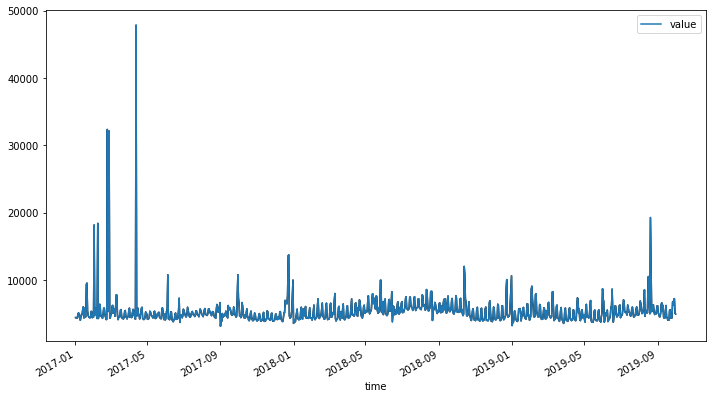

In [5]:
ts = TimeSeriesData(time=ts_sales_ST04.time, value=ts_sales_ST04.value)
ts.plot(cols=['value'])
plt.show()

## Forecasting with Kats

Kats currently support the following 10 base forecasting models: 

1. Linear  
2. Quadratic   
3. ARIMA   
4. SARIMA   
5. Holt-Winters   
6. Prophet   
7. AR-Net   
8. LSTM   
9. Theta   
10. VAR   

Each models follows the `sklearn` model API pattern:  we create an instance of the model class and then call its `fit` and `predict` methods.  In this section, we provide examples for the Prophet and Theta models.  A more in-depth introduction to forecasting in Kats is provided in [kats_201_forecasting.ipynb](https://github.com/facebookresearch/Kats/blob/main/tutorials/kats_201_forecasting.ipynb).

We will use Prophet as an example on our dataset:

In [6]:
# import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(ts, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
fcst = m.predict(steps=30, freq="D")

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
# the predict method returns a dataframe as follows
ts

,time,value
0,2017-01-02,4444.397
1,2017-01-03,4451.885
2,2017-01-04,4343.904
3,2017-01-05,4416.462
4,2017-01-06,4982.824
...,...,...
998,2019-09-27,6321.693
999,2019-09-28,7134.118
1000,2019-09-29,7256.165
1001,2019-09-30,5077.001


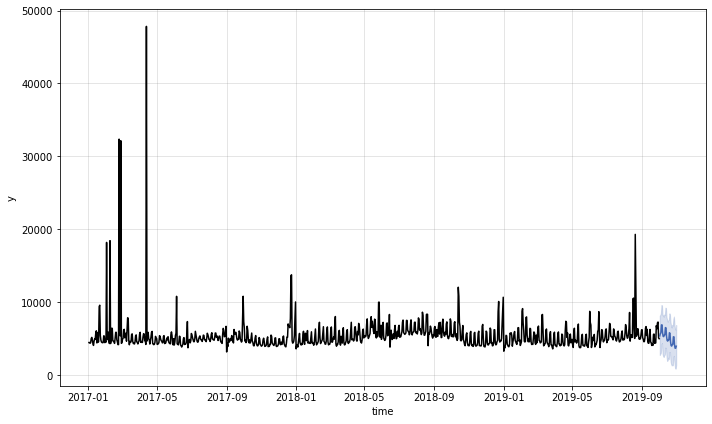

In [11]:
# visualize the results with uncertainty intervals
m.plot()

In [16]:
temp1 = fcst[['time', 'fcst']]

In [17]:
temp1 = temp1.rename(columns={"fcst": "value"})

In [18]:
temp2 = ts_sales_ST04[['time', 'value']]

In [19]:
frames = [temp2, temp1]

In [20]:
result = pd.concat(frames)

In [21]:
result = temp1.rename(columns={"time": "date", "value": "sales"})

,time,value
0,2017-01-02,4444.397000
1,2017-01-03,4451.885000
2,2017-01-04,4343.904000
3,2017-01-05,4416.462000
4,2017-01-06,4982.824000
...,...,...
25,2019-10-27,5219.399012
26,2019-10-28,4105.278473
27,2019-10-29,3664.951986
28,2019-10-30,3665.357848


In [32]:
a = result.to_numpy()

In [29]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [33]:
print(str(a))

[[Timestamp('2017-01-02 00:00:00') 4444.396999999999]
 [Timestamp('2017-01-03 00:00:00') 4451.885]
 [Timestamp('2017-01-04 00:00:00') 4343.904]
 ...
 [Timestamp('2019-10-29 00:00:00') 3664.951985911172]
 [Timestamp('2019-10-30 00:00:00') 3665.3578476107828]
 [Timestamp('2019-10-31 00:00:00') 3942.920995828489]]


In [34]:
pd.set_option('display.max_rows', 500)

In [35]:
print(str(a))

[[Timestamp('2017-01-02 00:00:00') 4444.396999999999]
 [Timestamp('2017-01-03 00:00:00') 4451.885]
 [Timestamp('2017-01-04 00:00:00') 4343.904]
 ...
 [Timestamp('2019-10-29 00:00:00') 3664.951985911172]
 [Timestamp('2019-10-30 00:00:00') 3665.3578476107828]
 [Timestamp('2019-10-31 00:00:00') 3942.920995828489]]


In [36]:
a

array([[Timestamp('2017-01-02 00:00:00'), 4444.396999999999],
       [Timestamp('2017-01-03 00:00:00'), 4451.885],
       [Timestamp('2017-01-04 00:00:00'), 4343.904],
       ...,
       [Timestamp('2019-10-29 00:00:00'), 3664.951985911172],
       [Timestamp('2019-10-30 00:00:00'), 3665.3578476107828],
       [Timestamp('2019-10-31 00:00:00'), 3942.920995828489]],
      dtype=object)

In [37]:
a.

"[[Timestamp('2017-01-02 00:00:00') 4444.396999999999]\n [Timestamp('2017-01-03 00:00:00') 4451.885]\n [Timestamp('2017-01-04 00:00:00') 4343.904]\n ...\n [Timestamp('2019-10-29 00:00:00') 3664.951985911172]\n [Timestamp('2019-10-30 00:00:00') 3665.3578476107828]\n [Timestamp('2019-10-31 00:00:00') 3942.920995828489]]"

In [38]:
np.set_printoptions(threshold = np.inf)

In [39]:
a

array([[Timestamp('2017-01-02 00:00:00'), 4444.396999999999],
       [Timestamp('2017-01-03 00:00:00'), 4451.885],
       [Timestamp('2017-01-04 00:00:00'), 4343.904],
       [Timestamp('2017-01-05 00:00:00'), 4416.4619999999995],
       [Timestamp('2017-01-06 00:00:00'), 4982.8240000000005],
       [Timestamp('2017-01-07 00:00:00'), 5148.352],
       [Timestamp('2017-01-08 00:00:00'), 4799.7519999999995],
       [Timestamp('2017-01-09 00:00:00'), 4301.346000000001],
       [Timestamp('2017-01-10 00:00:00'), 4046.7620000000006],
       [Timestamp('2017-01-11 00:00:00'), 4632.27],
       [Timestamp('2017-01-12 00:00:00'), 4928.7029999999995],
       [Timestamp('2017-01-13 00:00:00'), 4865.656999999998],
       [Timestamp('2017-01-14 00:00:00'), 5724.4439999999995],
       [Timestamp('2017-01-15 00:00:00'), 6050.448],
       [Timestamp('2017-01-16 00:00:00'), 4385.588000000002],
       [Timestamp('2017-01-17 00:00:00'), 5821.825999999999],
       [Timestamp('2017-01-18 00:00:00'), 4480.1